<a href="https://colab.research.google.com/github/glytch3/Sem-VI-Labs/blob/main/DWDM-Lab/Cyber_Bullying_Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=8e755111965f1261c59e736e2a0cd128a12fdff9f35d79e0d7e6660376b30ab7
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import pickle

# Getting data

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import csv
result = []

with open("/content/drive/MyDrive/DWDMLab/8000age.txt", "r") as file:
    lines = file.readlines()
for line in lines:
    result.append((line.strip(),"age"))

with open("/content/drive/MyDrive/DWDMLab/8000ethnicity.txt", "r") as file:
    lines = file.readlines()
for line in lines:
    result.append((line.strip(),"ethnicity"))

with open("/content/drive/MyDrive/DWDMLab/8000gender.txt", "r") as file:
    lines = file.readlines()
for line in lines:
    result.append((line.strip(),"gender"))

with open("/content/drive/MyDrive/DWDMLab/8000notcb.txt", "r") as file:
    lines = file.readlines()
for line in lines:
    result.append((line.strip(),"not_cyberbullying"))

with open("/content/drive/MyDrive/DWDMLab/8000other.txt", "r") as file:
    lines = file.readlines()
for line in lines:
    result.append((line.strip(),"other_cyberbullying"))

with open("/content/drive/MyDrive/DWDMLab/8000religion.txt", "r") as file:
    lines = file.readlines()
for line in lines:
    result.append((line.strip(),"religion"))

with open("/content/drive/MyDrive/DWDMLab/my_cyberbullying_tweets.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["tweet_text", "cyberbullying_type"])
    writer.writerows(result)

print("Output saved to output.csv")

Output saved to output.csv


In [77]:
data = pd.read_csv('/content/drive/MyDrive/DWDMLab/cyberbullying_tweets.csv')

# Initial Review

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [12]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


# Checking Missing Values

In [13]:
data.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

## No Missing Values found!

In [14]:
data['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

## Renaming columns for better understanding

In [15]:
data = data.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [16]:
data.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


### Adding Encoded column for sentiments

In [17]:
data["sentiment_encoded"] = data['sentiment'].replace({"religion": 1, "age": 2, "ethnicity": 3, "gender": 4, "other_cyberbullying": 5,"not_cyberbullying": 6})

In [18]:
data.head()

,text,sentiment,sentiment_encoded
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6


In [21]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Preprocessing of Text

## Function to Remove Emojis

In [22]:
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

## Fucntion to Convert text to lowercase, remove (/r, /n  characters), URLs, non-utf characters, Numbers, punctuations,stopwords

In [23]:
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('[0-9]+', '', text)
    stopchars= string.punctuation
    table = str.maketrans('', '', stopchars)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

## Function to remove contractions

In [24]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

## Function to Clean Hashtags

In [25]:
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

## Function to Filter Special Characters such as $, &

In [26]:
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

## Function to remove mutiple sequence spaces

In [27]:
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)


## Function to apply stemming to words

In [28]:
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

## Function to apply lemmatization to words

In [29]:
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

## Function to Preprocess the text by applying all above functions

In [30]:
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    text = lemmatize(text)
    return text

In [33]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
data['cleaned_text'] = data['text'].apply(preprocess)
data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,sentiment,sentiment_encoded,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...


## Cleaned text added

## Dealing with Duplicates

In [34]:
data["cleaned_text"].duplicated().sum()

3041

In [35]:
data.drop_duplicates("cleaned_text", inplace=True)

# Duplicates removed

# Tokenization

In [36]:
data['tweet_list'] = data['cleaned_text'].apply(word_tokenize)
data.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like..."


# Checking length of various tweet texts

In [37]:
text_len = []
for text in data.tweet_list:
    tweet_len = len(text)
    text_len.append(tweet_len)
data['text_len'] = text_len

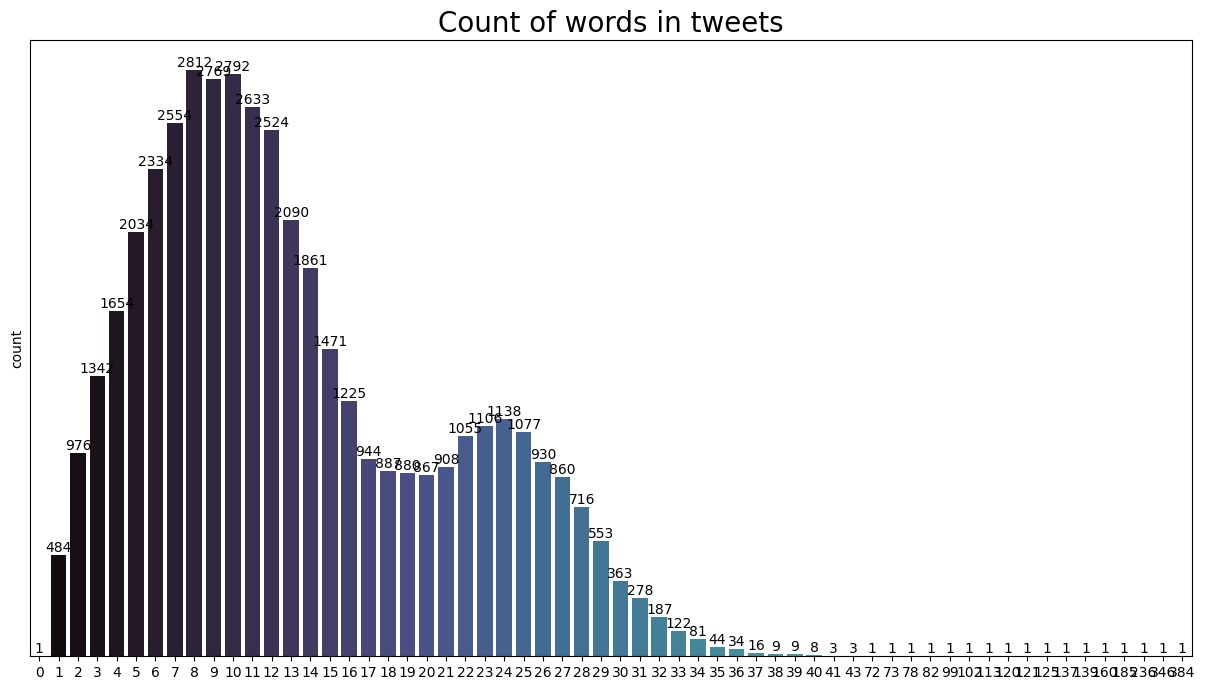

In [38]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='text_len', data=data, palette='mako')
plt.title('Count of words in tweets', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Removing text without words

In [39]:
data = data[data['text_len']!=0]

In [40]:
data.shape

(44650, 6)

# Function to create WordCloud

In [41]:
def plot_wordcloud(cyberbullying_type):
    string = ""
    for i in data[data.sentiment == cyberbullying_type].cleaned_text.values:
        string = string + " " + i.strip()

    custom_mask = np.array(Image.open('statics/twitter.png'))
    mask_colors = ImageColorGenerator(custom_mask)
    wordcloud = WordCloud(background_color ='white',max_words=2000, max_font_size=256,
               random_state=42, width=custom_mask.shape[1],height=custom_mask.shape[0],
                mask = custom_mask,min_font_size = 10,color_func=mask_colors).generate(string)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(cyberbullying_type)
    plt.show()
    del string

# Splitting data based on sentiment for Data Exploration

In [42]:
not_cyberbullying_type = data[data['sentiment']=='not_cyberbullying']
gender_type = data[data['sentiment']=='gender']
religion_type = data[data['sentiment']=='religion']
other_cyberbullying_type = data[data['sentiment']=='other_cyberbullying']
age_type = data[data['sentiment']=='age']
ethnicity_type = data[data['sentiment']=='ethnicity']

# Exploratory Data Analysis

# Gender Based Cyberbullying

In [43]:
gender = Counter([item for sublist in gender_type['tweet_list'] for item in sublist])
top20_gender = pd.DataFrame(gender.most_common(20))
top20_gender.columns = ['Top Words','Count']
top20_gender.style.background_gradient(cmap='Greens')

,Top Words,Count
0,joke,5179
1,rape,4070
2,gay,3852
3,call,1401
4,make,1283
5,rt,1221
6,woman,1182
7,bitch,1146
8,femal,1108
9,peopl,988


Text(0.5, 1.0, 'Top 20 words in Gender Cyberbullying')

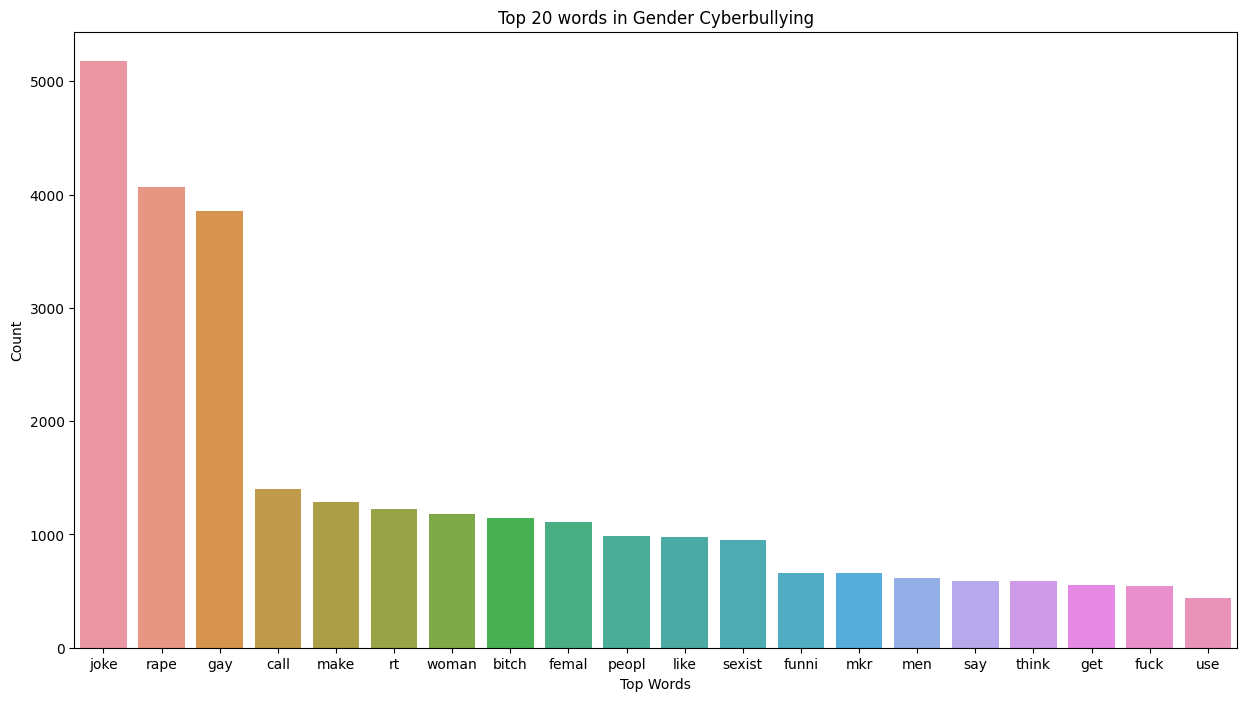

In [44]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_gender, y="Count", x="Top Words")
plt.title("Top 20 words in Gender Cyberbullying")

# Religion Based Cyberbullying

In [46]:
religion = Counter([item for sublist in religion_type['tweet_list'] for item in sublist])
top20_religion = pd.DataFrame(religion.most_common(20))
top20_religion.columns = ['Top Words','Count']
top20_religion.style.background_gradient(cmap='Greens')

,Top Words,Count
0,muslim,4618
1,idiot,3075
2,islam,2440
3,christian,2132
4,u,1922
5,terrorist,1378
6,right,1289
7,like,1276
8,support,1251
9,woman,1247


Text(0.5, 1.0, 'Top 20 words in Religion Cyberbullying')

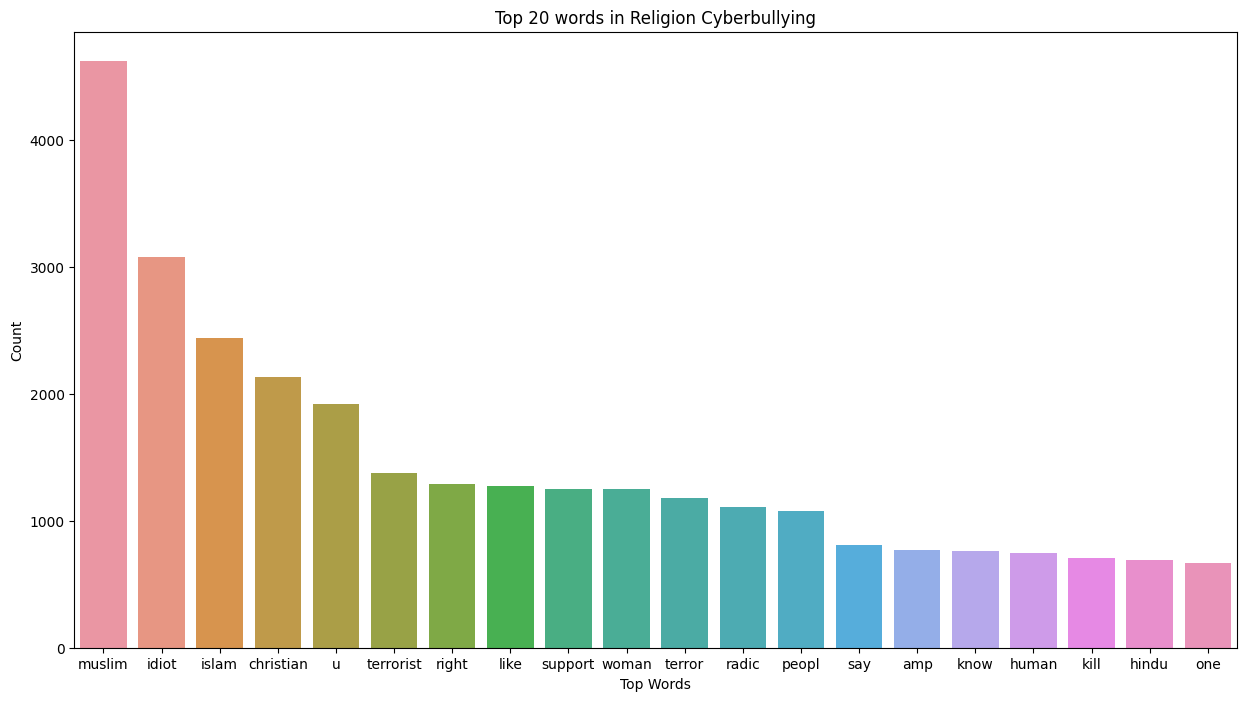

In [47]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_religion, y="Count", x="Top Words")
plt.title("Top 20 words in Religion Cyberbullying")

# Age based Cyberbullying

In [48]:
age = Counter([item for sublist in age_type['tweet_list'] for item in sublist])
top20_age = pd.DataFrame(age.most_common(20))
top20_age.columns = ['Top Words','Count']
top20_age.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,8899
1,school,8426
2,high,4861
3,girl,4616
4,like,2076
5,get,1051
6,one,1044
7,peopl,934
8,got,842
9,kid,809


Text(0.5, 1.0, 'Top 20 words in Age Cyberbullying')

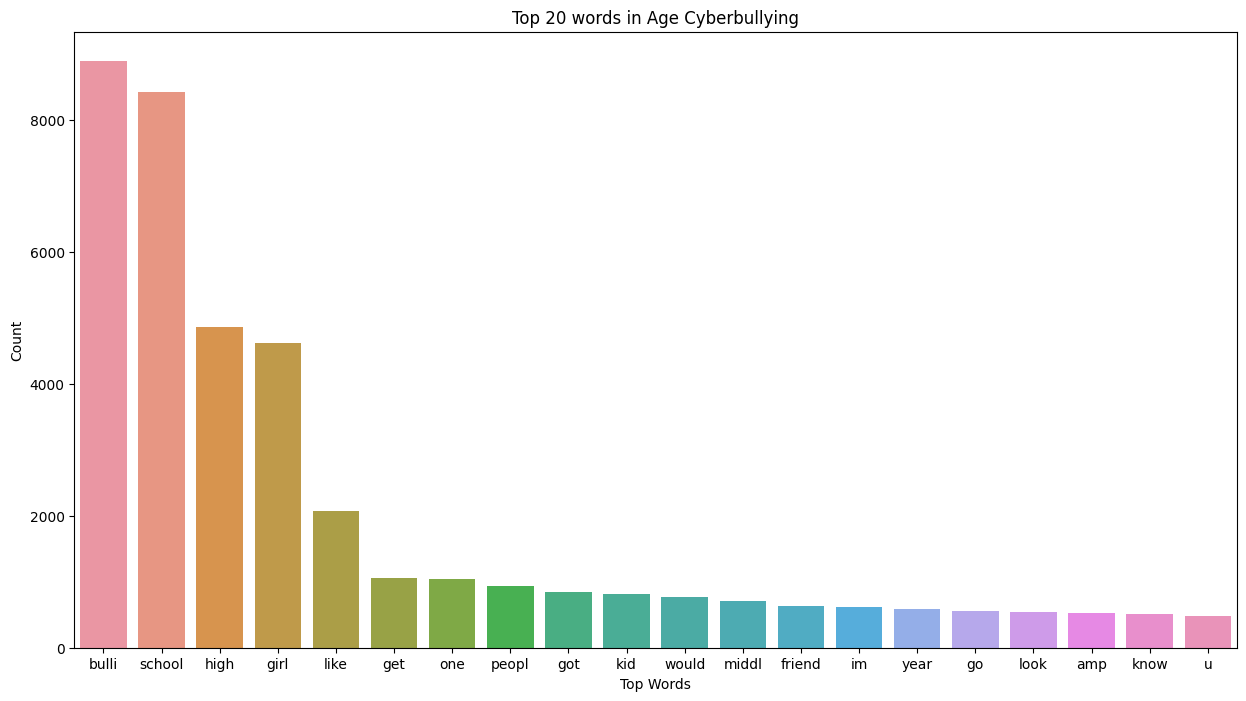

In [49]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_age, y="Count", x="Top Words")
plt.title("Top 20 words in Age Cyberbullying")

# Ethnicity based Cyberbullying

In [50]:
ethnicity = Counter([item for sublist in ethnicity_type['tweet_list'] for item in sublist])
top20_ethnicity = pd.DataFrame(ethnicity.most_common(20))
top20_ethnicity.columns = ['Top Words','Count']
top20_ethnicity.style.background_gradient(cmap='Greens')

,Top Words,Count
0,fuck,5892
1,nigger,5456
2,dumb,5003
3,as,2241
4,black,2134
5,u,2107
6,white,1557
7,call,1381
8,peopl,1182
9,rt,1166


Text(0.5, 1.0, 'Top 20 words in Ethnicity Cyberbullying')

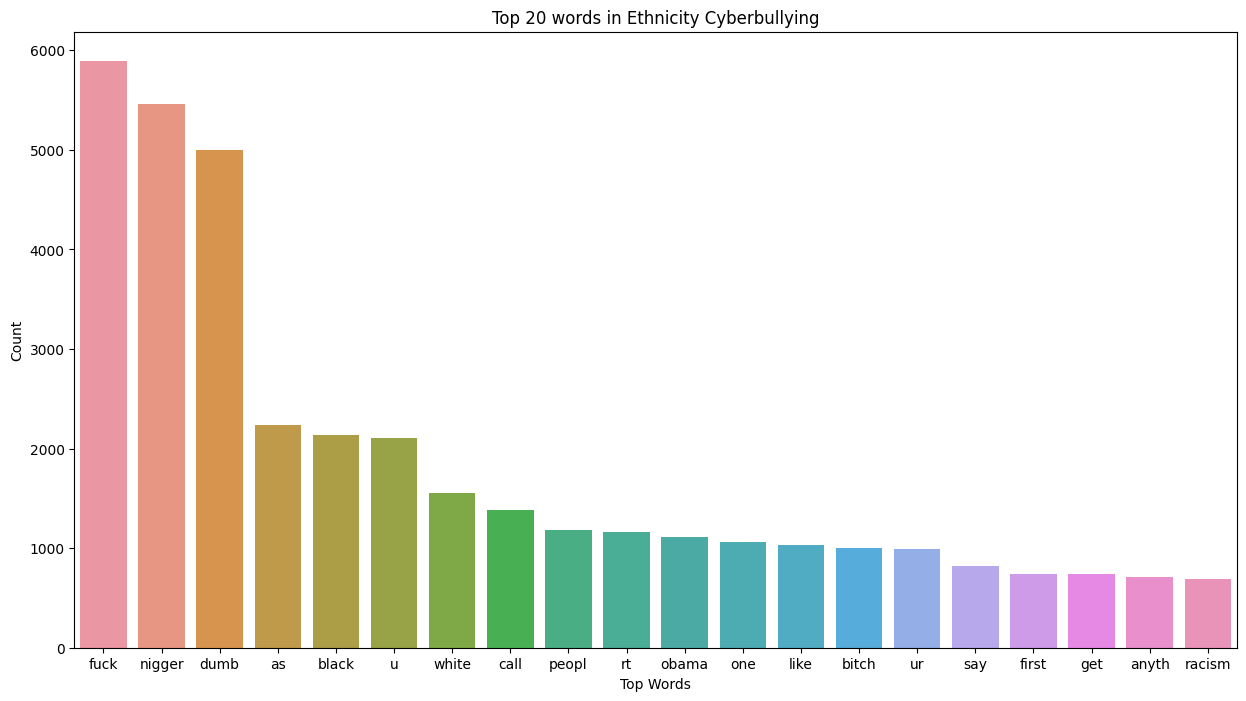

In [51]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_ethnicity, y="Count", x="Top Words")
plt.title("Top 20 words in Ethnicity Cyberbullying")

# Other types of Cyberbullying

In [52]:
other_cyberbullying = Counter([item for sublist in other_cyberbullying_type['tweet_list'] for item in sublist])
top20_other_cyberbullying = pd.DataFrame(other_cyberbullying.most_common(20))
top20_other_cyberbullying.columns = ['Top Words','Count']
top20_other_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,882
1,rt,727
2,fuck,509
3,like,424
4,get,393
5,peopl,353
6,go,277
7,idiot,261
8,know,241
9,think,237


Text(0.5, 1.0, 'Top 20 words in Other Cyberbullying')

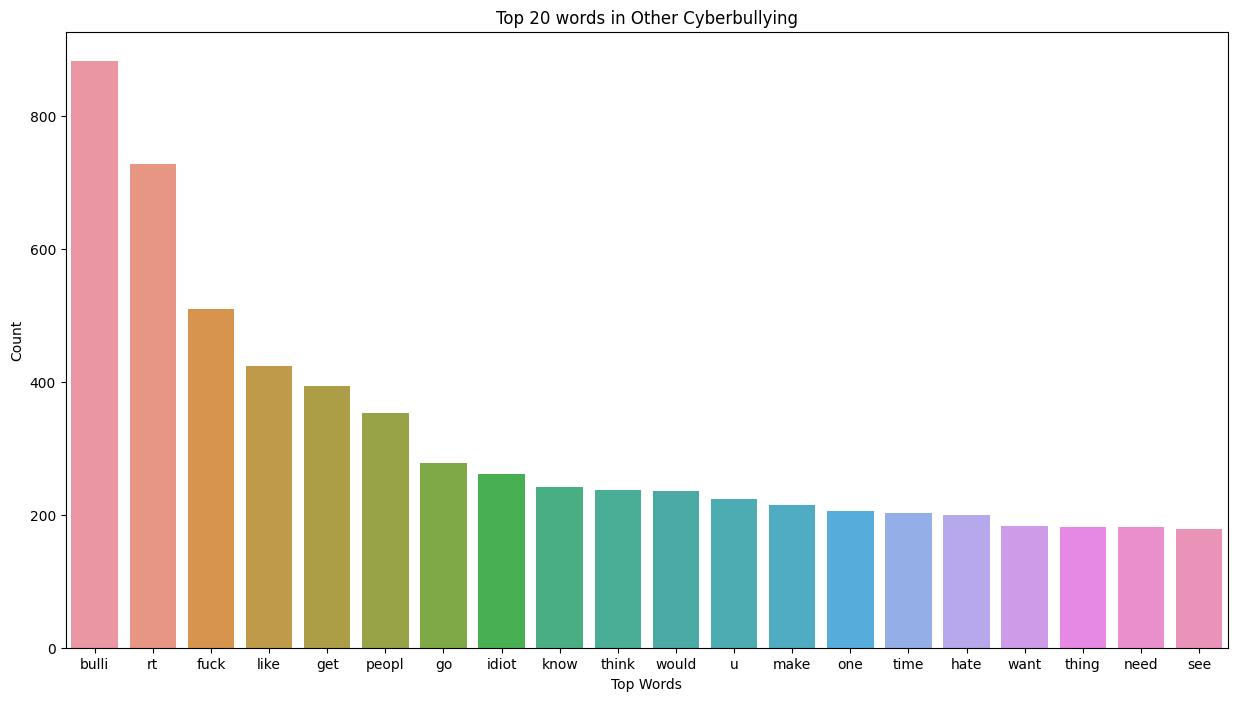

In [53]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_other_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Other Cyberbullying")

# Tweets without Cyberbullying

In [54]:
not_cyberbullying = Counter([item for sublist in not_cyberbullying_type['tweet_list'] for item in sublist])
top20_not_cyberbullying = pd.DataFrame(not_cyberbullying.most_common(20))
top20_not_cyberbullying.columns = ['Top Words','Count']
top20_not_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,mkr,1674
1,bulli,1102
2,rt,785
3,like,424
4,get,423
5,go,394
6,school,374
7,kat,286
8,would,286
9,peopl,272


Text(0.5, 1.0, 'Top 20 words in Not Cyberbullying')

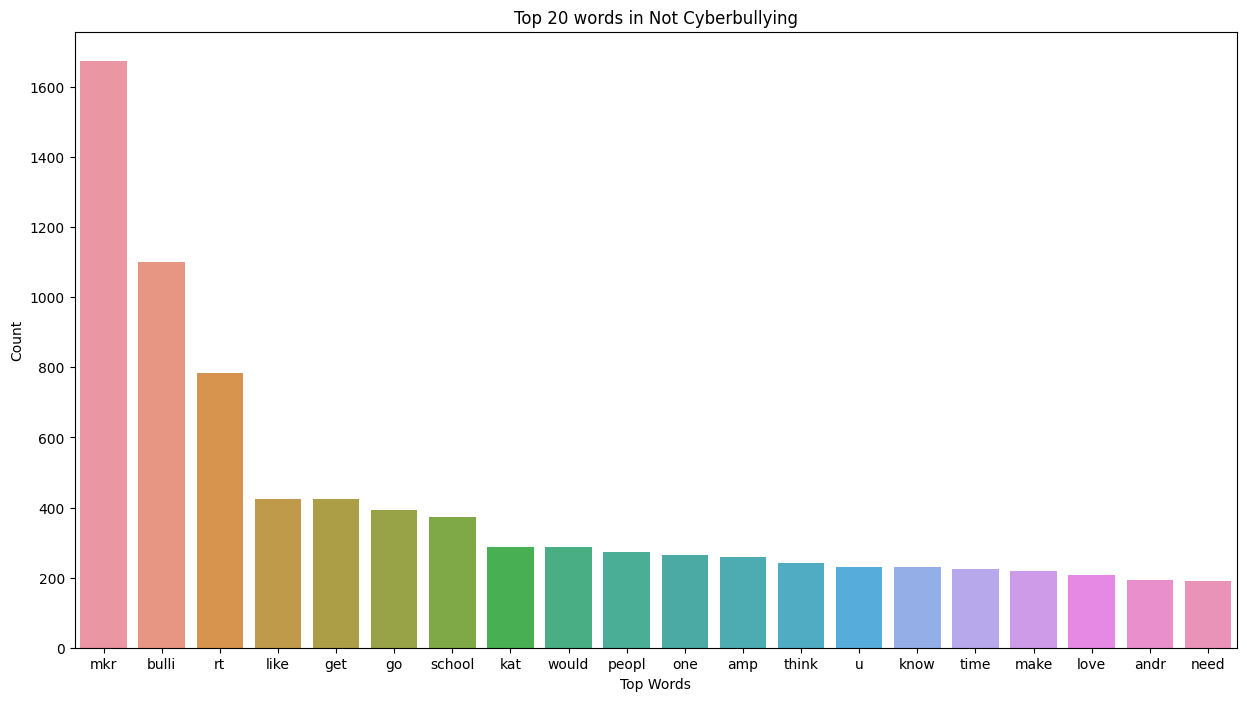

In [55]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_not_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Not Cyberbullying")

In [56]:
data.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]",5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya...",11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]",5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d...",9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like...",8


In [58]:
sentiments = ["religion", "age", "ethnicity", "gender", "other_cyberbullying","not_cyberbullying"]

# Splitting Data into Train and Test Sets

The first line of code X,Y = data['cleaned_text'],data['sentiment_encoded'] assigns two variables X and Y to the cleaned_text and sentiment_encoded columns of the data dataframe, respectively.

The second line of code train_test_split(X, Y, test_size = 0.3, stratify =Y, random_state = 42) uses the train_test_split function from scikit-learn library to split the data into training and testing sets.

The test_size parameter specifies the proportion of the data that should be allocated to the testing set. In this case, 30% of the data is allocated to the testing set, and the remaining 70% is allocated to the training set.

The stratify parameter ensures that the proportion of each class in the original dataset is preserved in both the training and testing sets. In this case, Y is used as the stratification variable to ensure that the proportion of each sentiment category is preserved in both the training and testing sets.

The random_state parameter sets the random seed for reproducibility.

The output of the train_test_split function is assigned to four variables: X_train, X_test, y_train, and y_test. X_train and y_train are the training data (inputs and outputs), and X_test and y_test are the testing data (inputs and outputs).

Finally, the last line of code print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) prints the shape of each split to verify the split was done correctly. The output (31255,) (31255,) (13395,) (13395,) indicates that the training data has 31255 rows, and the testing data has 13395 rows, and both training and testing outputs have the same number of rows.

In [59]:
X,Y = data['cleaned_text'],data['sentiment_encoded']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify =Y, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(31255,) (31255,) (13395,) (13395,)


## tf-idf Vectorization

Used to transform text data into a format that can be used in machine learning models. It assigns a numerical score to each word in a document, based on how often it appears in the document. This approach is useful because it can help identify words that are important to a document while filtering out words that appear commonly across many documents. It also ensures that the testing data is transformed using the same set of features as the training data, which is important for accurate model evaluation.

In [61]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)
print(X_train_tf.shape)
print(X_test_tf.shape)

(31255, 29111)
(13395, 29111)


# Trying Different ML Models

## Logistic Regression

Initializes an instance of the LogisticRegression class from the scikit-learn library.
Performs 5-fold cross-validation on the training data using the logistic regression model log_reg.

In [62]:
log_reg = LogisticRegression()

In [63]:
log_cv_score = cross_val_score(log_reg,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)

In [64]:
mean_log_cv = np.mean(log_cv_score)
mean_log_cv

0.8228272280708214

## Support Vector Classifier

The X_train_tf and y_train are two sets of data - X_train_tf contains the data that the model uses to learn the patterns, and y_train contains the correct answers to the patterns in X_train_tf.

The cross_val_score() function helps to test the accuracy of the model. It splits the data into five groups (known as "folds") and then trains the model on four of the folds, while testing it on the remaining fold. 

The mean_lin_svc_cv variable stores the average F1 score calculated by the cross_val_score() function, so it gives us an idea of how well the model is likely to perform in general, not just on the training data. 

In [65]:
lin_svc = LinearSVC()

In [66]:
lin_svc_cv_score = cross_val_score(lin_svc,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score)
mean_lin_svc_cv

0.8220066371295554

## RandomForest Classifier 

In [67]:
rand_forest = RandomForestClassifier()

In [68]:
rand_forest_cv_score = cross_val_score(rand_forest,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_rand_forest_cv = np.mean(rand_forest_cv_score)
mean_rand_forest_cv

0.8295161794693078

We can see logistic regression, svm and random forest classifier performed similarly, so among these we will go with svm model as it is more generalised and light

## Fine Tuning Support Vector Classifier

Using Grid Search to find the best hyperparameters for the model, to optimize the performance of the model and improve its accuracy on the test data. Grid Search is a technique used to search for the best combination of hyperparameters by trying all possible combinations and selecting the one that gives the best performance.

In [69]:
svc1 = LinearSVC()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10],
             'loss':['hinge','squared_hinge'],
             'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(X_train_tf,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='f1_macro')

In [70]:
grid_search.best_estimator_

LinearSVC(C=1, loss='hinge')

In [71]:
grid_search.best_score_

0.8244012024546198

# Model Evaluation

In [72]:
lin_svc.fit(X_train_tf,y_train)
y_pred = lin_svc.predict(X_test_tf)

In [73]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

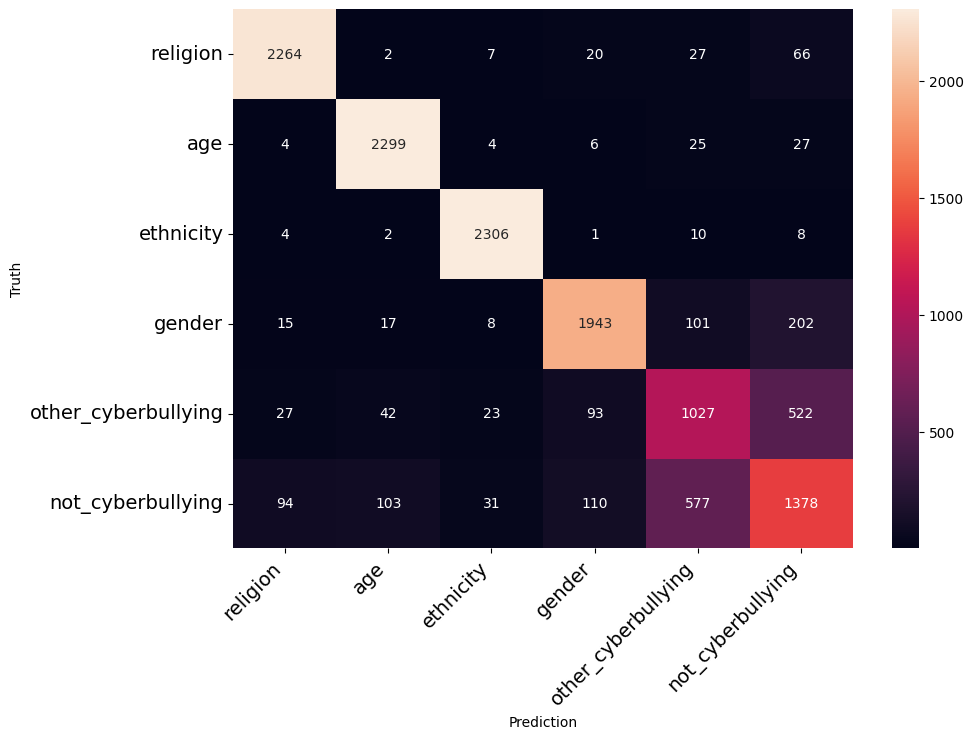

In [74]:
cm = confusion_matrix(y_test,y_pred)
print_confusion_matrix(cm,sentiments)

Number of correct and incorrect predictions made by the model on a test dataset

In [75]:
print('Classification Report:\n',classification_report(y_test, y_pred, target_names=sentiments))

Classification Report:
                      precision    recall  f1-score   support

           religion       0.94      0.95      0.94      2386
                age       0.93      0.97      0.95      2365
          ethnicity       0.97      0.99      0.98      2331
             gender       0.89      0.85      0.87      2286
other_cyberbullying       0.58      0.59      0.59      1734
  not_cyberbullying       0.63      0.60      0.61      2293

           accuracy                           0.84     13395
          macro avg       0.82      0.83      0.82     13395
       weighted avg       0.84      0.84      0.84     13395



In [76]:
pickle.dump(tf_idf, open('vectorizer.pkl', 'wb'))
pickle.dump(lin_svc, open('model.pkl', 'wb'))